### Задание к Уроку 3.
### Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#



1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?


### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

#### 1. EDA (короткий)

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

**Объективные признаки:**

 - Возраст
 - Рост
 - Вес
 - Пол
 

**Результаты измерения:**

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

**Субъективные признаки:**

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

**Таргет** - наличие сердечно-сосудистых заболеваний (ССЗ)

#### 2. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



#### 3. Импорт данных

In [3]:
df = pd.read_csv('train_case2.csv', delimiter=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


#### 4. Разделение данных на тренировочную и тестовую выборки

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'], random_state=0)

#### 5. Обработка признаков

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    continuos_transformers.append((cont_col, transfomer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
        ('selector', ColumnSelector(key=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))
    ])
    base_transformers.append((base_col, base_transformer))

In [ ]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 5. Создание конечного pipeline

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [56]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)
feature_processing = Pipeline([('feats', feats)])

ft = feature_processing.fit_transform(X_train)
pd.DataFrame(ft).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.733918,0.687330,0.748439,0.008546,-0.091174,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0
1,-1.673435,0.077589,-0.296401,-0.128507,-0.144553,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.137381,1.175123,-0.157089,-0.059980,-0.091174,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.460901,-0.654100,-0.505369,0.145600,0.015584,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
4,-1.410804,0.809278,0.539471,-0.128507,-0.091174,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [58]:
# pd.DataFrame(ft).describe().T

,count,mean,std,min,25%,50%,75%,max
0,52500.0,3.835577e-16,1.000010,-3.525656,-0.722361,0.090294,0.753672,1.716823
1,52500.0,4.716650e-16,1.000010,-13.092813,-0.654100,0.077589,0.687330,10.443184
2,52500.0,-4.566421e-16,1.000010,-4.475762,-0.644681,-0.157089,0.539471,8.758881
3,52500.0,-5.440727e-17,1.000010,-1.910196,-0.059980,-0.059980,0.077073,108.897169
4,52500.0,6.225708e-18,1.000010,-0.518204,-0.091174,-0.091174,-0.037795,52.860635
5,52500.0,6.490095e-01,0.477285,0.000000,0.000000,1.000000,1.000000,1.000000
6,52500.0,3.509905e-01,0.477285,0.000000,0.000000,0.000000,1.000000,1.000000
7,52500.0,7.473143e-01,0.434556,0.000000,0.000000,1.000000,1.000000,1.000000
8,52500.0,1.376952e-01,0.344583,0.000000,0.000000,0.000000,0.000000,1.000000
9,52500.0,1.149905e-01,0.319013,0.000000,0.000000,0.000000,0.000000,1.000000


In [21]:
from sklearn import set_config

set_config(display='diagram')
feature_processing

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='weight')),
                                                                 ('standard',
                                                                  StandardScaler())]...
                                                                  ColumnSelector(key='cholesterol')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='cholesterol'))])),
                                                ('gluc',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='gluc'))])),
                                                ('smoke',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='smoke'))])),
                                                ('alco',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='alco'))])),
                                                ('active',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='active'))]))]))])

In [22]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# формирование roc auc кривой
def plot_roc_auc(y_test=None, y_score=None):
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))

    plt.plot(fpr, tpr, lw=2, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    # plt.savefig("ROC.png")
    plt.show()

#### 5. Добавление модели и кросс-валидации

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# model = LogisticRegression(random_state=42)
# model = KNeighborsClassifier(n_neighbors=4)
# model =  DecisionTreeClassifier(max_depth=6)
# model =  RandomForestClassifier(max_depth=6, max_features=5, n_estimators=100)
# model =  SVC(gamma='auto') до 10 000, у нас 50 000
model =  SGDClassifier()

In [122]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', model),
])

In [123]:
X_train

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
4497,6369,15212,2,170,85.0,130,80,3,3,1,0,1
8301,11845,15361,1,165,70.0,110,70,1,1,0,0,1
63679,90920,19822,1,174,72.0,120,80,1,1,0,0,0
3947,5584,20619,1,159,67.0,150,100,2,2,0,0,0
16013,22867,16008,1,171,82.0,110,80,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21243,30345,23289,1,158,76.0,120,80,3,3,0,0,0
45891,65548,23346,2,170,122.0,130,80,3,3,0,1,1
42613,60883,22385,2,174,72.0,120,80,1,1,0,0,1
43567,62243,18321,1,153,85.0,120,80,1,1,0,0,1


In [ ]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

In [120]:
# y_score
# y_test.values
# from sklearn.metrics import accuracy_score
#
# accuracy_score(y_test.values, y_score)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Посчитаем precision/recall/f_score

In [114]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.395805, F-Score=0.738, Precision=0.679, Recall=0.809


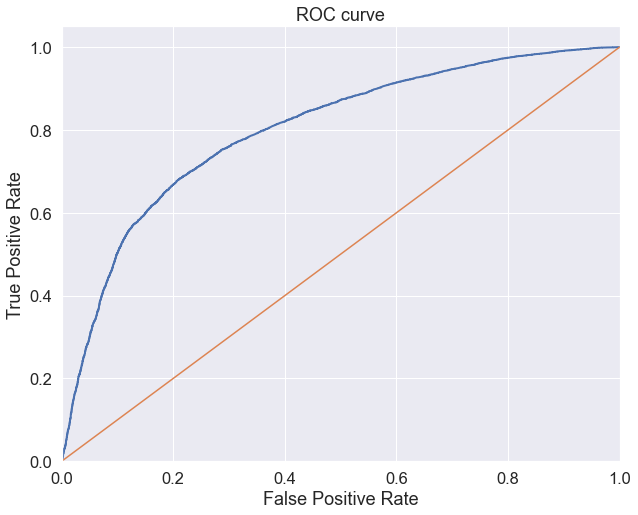

In [115]:
plot_roc_auc(y_test=y_test, y_score=y_score)


In [116]:
from sklearn.metrics import roc_auc_score, log_loss

roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:, 1])

#Ваш код здесь
print("roc auc score: {}".format(roc_auc))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:, 1])))

roc auc score: 0.7999090749971263
log loss score: 0.5453690969876345


Посомтрим на матрицу ошибок


Confusion matrix, without normalization
[[5494 3326]
 [1656 7024]]


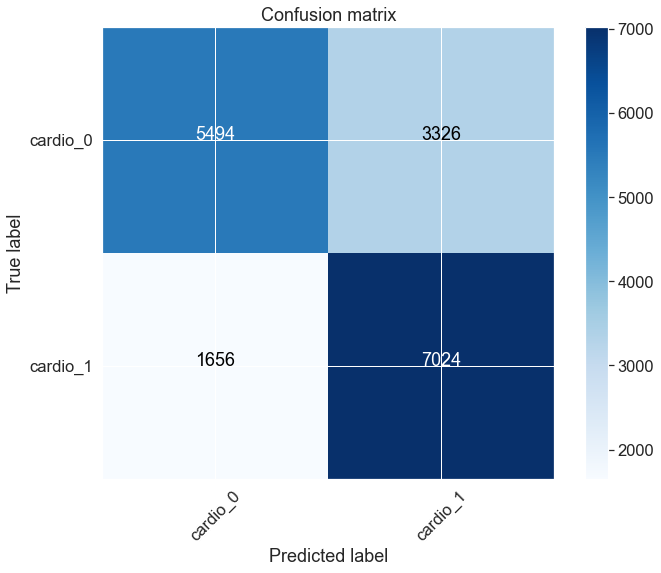

In [117]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
# font = {'size': 15}
# plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [118]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (FP + TN)
TPR, FPR, TNR

(0.8092165898617512, 0.37709750566893424, 0.6229024943310658)

False Positive Rate - ошибка - если болезнь наблюдается у здорового

In [119]:
print(
    f'{model.__class__.__name__} |  {round(precision[ix], 2)} | {round(recall[ix], 2)} |  {round(roc_auc, 2)} | {round(fscore[ix], 2)}')

RandomForestClassifier |  0.68 | 0.81 |  0.8 | 0.74


| Model                | precision | recall | roc_auc | f_score
| -- | -- |-- |-- |--|
LogisticRegression |  0.65 | 0.84 | 0.78 | 0.73
~~KNeighborsClassifier_4~~ |  ~~0.54~~ | ~~0.92~~ |  ~~0.68~~ | ~~0.68~~
KNeighborsClassifier_5 |  0.59 | 0.82 |  0.69 | 0.69
KNeighborsClassifier_6 |  0.57 | 0.87 |  0.7 | 0.69
RandomForestClassifier |  0.68 | 0.81 |  0.8 | 0.74

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic